# Finding Heavy Traffic Indicators on I-94

## Table of Contents
1. [**Introduction**](#1.-Introduction)
    1. Goal
    2. Dataset Description
2. [**Preparing & Reading the Data**](#2.-Preparing-&-Reading-the-Data)
    1. Importing Libraries
    2. Defining Functions
    3. Reading & Exploring the Dataset
    4. Measurement DataFrames
3. [**Analyzing Total Traffic Volume**](#3.-Analyzing-Total-Traffic-Volume)
4. [**Analyzing Time Indicators**](#4.-Analyzing-Time-Indicators)
    1. Daytime vs. Nighttime
    2. Month
    3. Day of the week
    4. Hour
5. [**Analyzing Weather Indicators**](#5.-Analyzing-Weather-Indicators)
    1. Numeric Weather Columns
    2. Weather Types
6. [**Visualizing Measurements**](#6.-Visualizing-Measurements)
7. [**Conclusion**](#7.-Conclusion)

___

## 1. Introduction
### Goal

The goal of this project is to find indicators of heavy traffic on I-94 and measure which indicators impact traffic the most.

[Interstate 94](https://en.wikipedia.org/wiki/Interstate_94) is an east–west Highway spanning roughly 1,555 miles from Montana to Michigan and crossing five other states (ND, MN, WI, IL, IN).

<img src="I-94.jpg" alt="Map of Interstate 94" title="Interstate 94" width="450" style="float: left; padding-top: 15px"/>

### Dataset Description
This dataset was created by John Hogue and can be downloaded from [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume).

According to the [documentation](https://archive.ics.uci.edu/dataset/492/metro+interstate+traffic+volume), this data was collected from an automatic traffic recorder (ATR) station located roughly midway between Minneapolis and St Paul, Minnesota. This station records traffic moving from east to west on I-94. 

Thus, the results of our analysis will only be regarding westbound traffic within proximity of this station.

Description of columns:
* `holiday`: US National holidays plus regional holiday
* `temp`: Average temp in kelvin
* `rain_1h`: Amount in mm of rain that occurred in the hour
* `snow_1h`: Amount in mm of snow that occurred in the hour
* `clouds_all`: Percentage of cloud cover
* `weather_main `: Short textual description of the current weather
* `weather_description`: Longer textual description of the current weather
* `date_time`: Hour of the data collected in local CST time
* `traffic_volume`: Hourly I-94 ATR 301 reported westbound traffic volume

___

## 2. Preparing & Reading the Data
### Importing Libraries

In [1]:
# Importing Libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Defining Functions
The following functions help to streamline this projects by abstracting repeated code.

In [2]:
def plot_traffic_hist(series, title):
    series.plot.hist(rwidth=0.95)
    plt.title(title, pad=16, fontsize=14)
    plt.xlabel('Traffic Volume (cars/hr)', labelpad=10, fontsize='11')
    plt.ylabel('Frequency', labelpad=10, fontsize='11')
    plt.xlim(-300, 7500)
    plt.ylim(0, 8500)
    
def plot_avg_traffic_line(series, x_label, title):
    series.mean().plot.line(linewidth=2)
    plt.title(title, pad=16, fontsize=14)
    plt.xlabel(x_label, labelpad=10, fontsize='11')
    plt.ylabel('Avg Traffic Volume (cars/hr)', labelpad=10, fontsize='11')
    plt.grid(True, color='black', alpha=0.1)
    
def plot_avg_traffic_barh(series, title):
    series.mean().sort_values().plot.barh()
    plt.title(title, pad=16, fontsize=14)
    plt.xlabel('Traffic Volume (cars/hr)', labelpad=10, fontsize='11')
    plt.ylabel('')


### Reading & Exploring the Dataset
Let's begin by getting a feel for what the dataset contains.

In [3]:
i_94 = pd.read_csv('Metro_Interstate_Traffic_Volume.csv')
i_94.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [4]:
i_94.tail()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
48199,NaN,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,3543
48200,NaN,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2781
48201,NaN,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159
48202,NaN,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,1450
48203,NaN,282.12,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 23:00:00,954


In [5]:
i_94.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              61 non-null     object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


**Initial Observations**
* Our dataset contains **9 columns** and **48,204 rows** with no null values.
* Each row corresponds to a specific hour of a day (*some days do not have all 24 hours recorded*).
* The data covers multiple years, beginning on 2012-10-02 and ending on 2018-09-30.

### Measurement DataFrame
This DataFrame will be used to tell which heavy traffic indicators impact traffic the most by storing their differences in the average cars per hour passing the station.

In [6]:
traffic_diff = pd.DataFrame()

___

## 3. Analyzing Total Traffic Volume
The `traffic_volume` column measures how many cars passed the station in a given hour.

Let's see what we can uncover about this column.

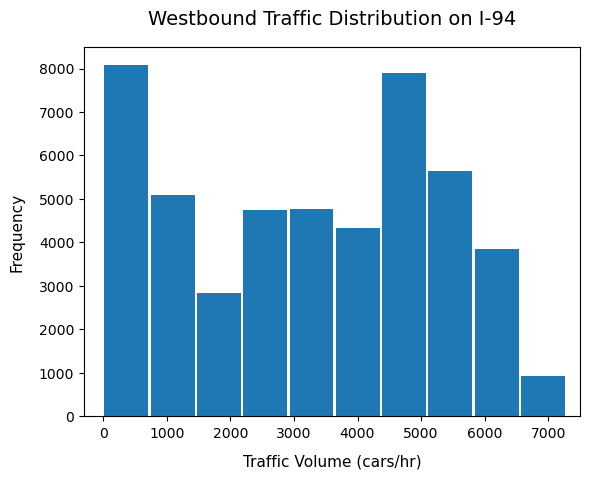

In [7]:
plot_traffic_hist(i_94['traffic_volume'], 'Westbound Traffic Distribution on I-94')
plt.show()

In [8]:
i_94['traffic_volume'].describe()

count    48204.000000
mean      3259.818355
std       1986.860670
min          0.000000
25%       1193.000000
50%       3380.000000
75%       4933.000000
max       7280.000000
Name: traffic_volume, dtype: float64

**Observations**
* The total traffic volume appears to have a random distribution.
* A range from 0 to 7280 cars passing the station per hour.
* An average of 3260 cars pass the station per hour.

___

## 4. Analyzing Time Indicators
People may drive more during certain times of the day, week, or year.

To examine this, lets first add four new columns to our data (`hour`, `dayofweek`, `month`, `year`) to make working with time easier.

In [9]:
i_94['date_time'] = pd.to_datetime(i_94['date_time'])
i_94['hour'] = i_94['date_time'].dt.hour
i_94['dayofweek'] = i_94['date_time'].dt.dayofweek
i_94['month'] = i_94['date_time'].dt.month
i_94['year'] = i_94['date_time'].dt.year

### Daytime vs. Nighttime
A likely indicator of heavy traffic is daylight, so let's compare how daytime varies from nighttime.

We'll split them as such:
* Day: 7am–7pm
* Night: 7pm–7am

These time frames are not a perfect gerneralization, but will do for the puproses of this project.

In [10]:
daytime = i_94.copy()[(i_94['date_time'].dt.hour >= 7) & (i_94['date_time'].dt.hour < 19)]
print(daytime.shape)

nighttime = i_94.copy()[(i_94['date_time'].dt.hour >= 19) | (i_94['date_time'].dt.hour < 7)]
print(nighttime.shape)

(23877, 13)
(24327, 13)


The number of rows do not match. This is because some days did not record all 24 hours. 

It appears more hours we're left untracked during the day than at night.

Next, let's examine the traffic distributions for Daytime vs Nightime and see what we find.

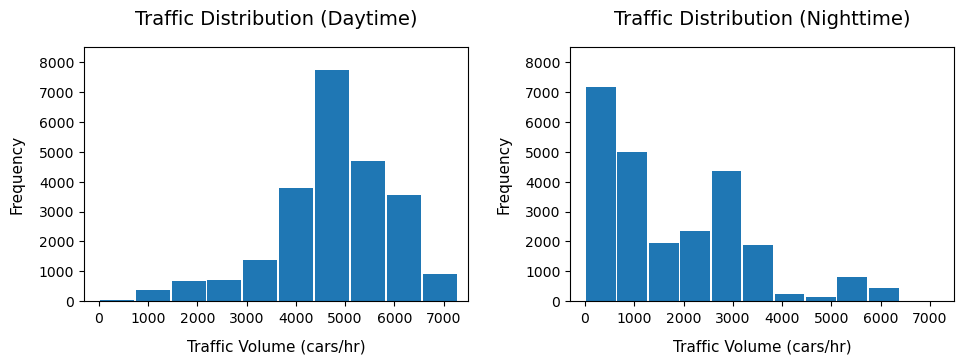

In [11]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plot_traffic_hist(daytime['traffic_volume'], 'Traffic Distribution (Daytime)')

plt.subplot(1, 2, 2)
plot_traffic_hist(nighttime['traffic_volume'], 'Traffic Distribution (Nighttime)')

plt.tight_layout(pad=2)
plt.show()

In [12]:
daytime['traffic_volume'].describe()

count    23877.000000
mean      4762.047452
std       1174.546482
min          0.000000
25%       4252.000000
50%       4820.000000
75%       5559.000000
max       7280.000000
Name: traffic_volume, dtype: float64

In [13]:
nighttime['traffic_volume'].describe()

count    24327.000000
mean      1785.377441
std       1441.951197
min          0.000000
25%        530.000000
50%       1287.000000
75%       2819.000000
max       6386.000000
Name: traffic_volume, dtype: float64

In [14]:
avg_day_vs_night_diff = daytime['traffic_volume'].mean() - nighttime['traffic_volume'].mean()
print(avg_day_vs_night_diff)

# Storing for later
traffic_diff['daytime vs nightime'] = [avg_day_vs_night_diff]

2976.670010818641


**Daytime Observations**
* The daytime distribution appears left skewed meaning we see higher than average traffic volume.
* The average traffic volume per hour during daytime is 4762 cars with a high of 7280 cars.

**Nighttime Observations**
* The nighttime distribution appears right skewed meaning we see lower than average traffic volume.
* The average traffic volume per hour during nightime is 1785 cars with a high of 6386 cars.

**Take Away**
* Daytime is an indicator of heavy traffic with **2,977** more cars per hour than nighttime.
* We'll be working with daytime traffic for the remainder of this project since nightime traffic is slow.

### Month

There may be some months where people drive more frequently. Let's test this theory.

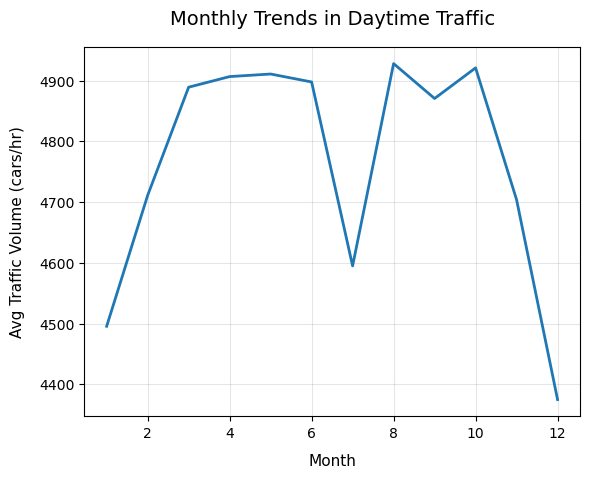

In [15]:
month = daytime.groupby('month')
plot_avg_traffic_line(month['traffic_volume'], 'Month', 'Monthly Trends in Daytime Traffic')

plt.show()

In [16]:
month['traffic_volume'].mean().describe()

count      12.000000
mean     4767.211825
std       190.013332
min      4374.834566
25%      4676.829675
50%      4880.096353
75%      4907.951131
max      4928.302035
Name: traffic_volume, dtype: float64

**Observations**
* Average daytime traffic can range from 4374 to 4928 cars per hour.
* Daytime traffic appears heavier during the warm months (March–October), with an exception being July.
* Daytime traffic appears slower during the cold months (November–February).

Let's examine this anomaly in July more closely.

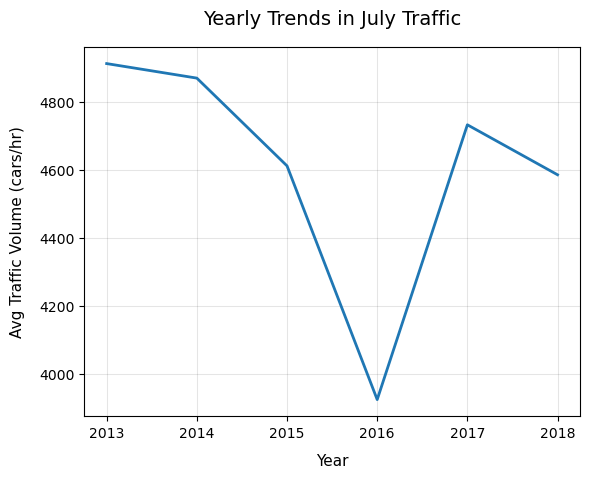

In [17]:
only_july = daytime[daytime['month'] == 7]
only_july_by_year = only_july.groupby('year')

plot_avg_traffic_line(only_july_by_year['traffic_volume'], 'Year', 'Yearly Trends in July Traffic')
plt.show()

In [18]:
only_july_by_year['traffic_volume'].mean().describe()

count       6.000000
mean     4607.507002
std       359.529340
min      3924.923645
25%      4593.461214
50%      4673.633264
75%      4837.228756
max      4914.354054
Name: traffic_volume, dtype: float64

**Observations**
* Average traffic in July ranges from 3924 to 4914 cars per hour.
* July usually has heavy traffic (more than 4600 cars per hour) except for a dip in 2016.

This dip is possibly due to road construction that was taking place on i-94 that year as seen in [this article from 2016](https://www.crainsdetroit.com/article/20160728/NEWS/160729841/weekend-construction-i-96-us-23-bridge-work-i-94-lane-closures-i-696).

Let's calculate the difference between warm and cold months.

In [19]:
warm_months = daytime.copy()[(daytime['month'] >= 3)  & (daytime['month'] <= 10)]
cold_months = daytime.copy()[(daytime['month'] <= 2) | (daytime['month'] >= 11)]
avg_warm_vs_cold_diff = warm_months['traffic_volume'].mean() - cold_months['traffic_volume'].mean()
print(avg_warm_vs_cold_diff)

# Storing for later
traffic_diff['warm months vs cold months'] = avg_warm_vs_cold_diff

299.35208254214376


**Take Away**
* Warm months (March–October) are an indicate of heavier traffic with 299 more cars per hour than cold months (November–February).

### Day of the week
Now let's examine how the days of the week affect traffic volume.

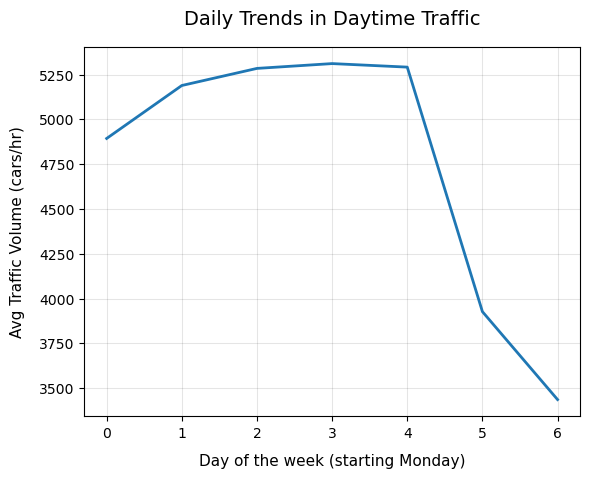

In [20]:
day_of_week = daytime.groupby('dayofweek')

plot_avg_traffic_line(day_of_week['traffic_volume'], 'Day of the week (starting Monday)', 'Daily Trends in Daytime Traffic')

plt.show()

In [21]:
day_of_week['traffic_volume'].mean().describe()

count       7.000000
mean     4761.958037
std       764.684759
min      3436.541789
25%      4410.400422
50%      5189.004782
75%      5288.027555
max      5311.303730
Name: traffic_volume, dtype: float64

In [22]:
business_days = daytime.copy()[daytime['dayofweek'] <= 4] #4 is Friday
weekend = daytime.copy()[daytime['dayofweek'] >= 5] #5 is Saturday
avg_business_vs_weekend_diff = business_days['traffic_volume'].mean() - weekend['traffic_volume'].mean()
print(avg_business_vs_weekend_diff)

# Storing for later
traffic_diff['business days vs weekends'] = avg_business_vs_weekend_diff

1509.7590943122673


**Observations**
* Daily average traffic can range from 3436 to 5311 cars per hour.
* Traffic is heavier on business days (Monday–Friday)
* Sunday's have particularly slow traffic.

**Take Away**
* Buisness Days are an indicator of heavy traffic with 1500 more cars per hour than weekends.

### Hour
Next, let's see how the time of the day impacts traffic. 

To keep the weekends from affecting the results, we'll examine them seperately from business days.

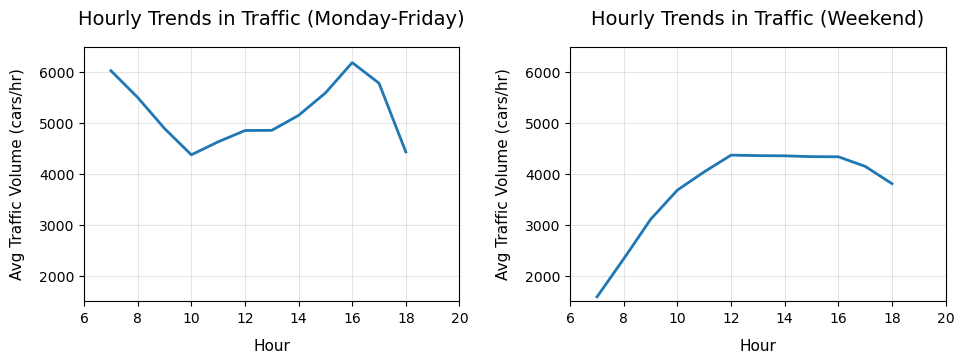

In [23]:
hour_business = business_days.groupby('hour')
hour_weekend = weekend.groupby('hour')

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plot_avg_traffic_line(hour_business['traffic_volume'], 'Hour', 'Hourly Trends in Traffic (Monday-Friday)')
plt.xlim(6, 20)
plt.ylim(1500, 6500)

plt.subplot(1, 2, 2)
plot_avg_traffic_line(hour_weekend['traffic_volume'], 'Hour', 'Hourly Trends in Traffic (Weekend)')
plt.xlim(6, 20)
plt.ylim(1500, 6500)

plt.tight_layout(pad=2)
plt.show()

In [24]:
rush_hour = business_days.copy()[(business_days['hour'] == 7) | (business_days['hour'] == 16)]
standard_hours = business_days.copy()[(business_days['hour'] != 7) & (business_days['hour'] != 16)]
avg_rush_vs_standard_diff = rush_hour['traffic_volume'].mean() - standard_hours['traffic_volume'].mean()
print(avg_rush_vs_standard_diff)

# Storing for later
traffic_diff['rush hour vs standard hours'] = avg_rush_vs_standard_diff

1104.3245563802402


**Observations**
* Traffic is busier during most hours of business days compared to weekends
* Rush hour (around 7am and 4pm) causes traffic spikes on business days that are not seen on weekends.
* Traffic gradually increases then decreases on weekends.

**Take Away**
* Rush hour is an indicator of heavy traffic with 1104 more cars per hour than standard hours.

___

## 5. Analyzing Weather Indicators
Bad weather is another likely indicator for heavy traffic.

The following columns relate to weather: `temp`, `rain_1h`, `snow_1h`, `clouds_all`, `weather_main`, `weather_description`.

### Numeric Weather Columns
Of these columns, the following are numeric: `temp`, `rain_1h`, `snow_1h`, `clouds_all`.

Let's begin by seeing how these four number columns correlate with `traffic_volume`.

In [25]:
daytime[['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'traffic_volume']].corr()['traffic_volume']

temp              0.128317
rain_1h           0.003697
snow_1h           0.001265
clouds_all       -0.032932
traffic_volume    1.000000
Name: traffic_volume, dtype: float64

We can see that `temp` (temperature) has the most correlation with a value of +0.128. The other numeric columns (`rain_1h`, `snow_1h`, `clouds_all`) have a negligible correlation, so we will ignore them.

We will now create a scatter plot to see the correlation between `temp` and `traffic_volume`.

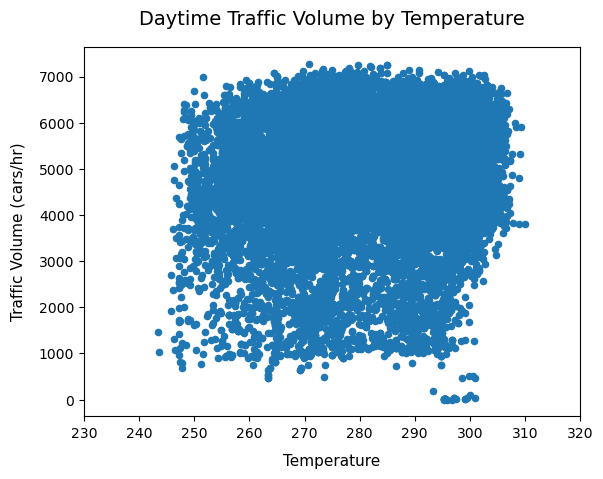

In [26]:
daytime.plot.scatter('temp', 'traffic_volume')
plt.xlim(230, 320)
plt.title('Daytime Traffic Volume by Temperature', pad=16, fontsize=14)
plt.xlabel('Temperature', labelpad=10, fontsize='11')
plt.ylabel('Traffic Volume (cars/hr)', labelpad=10, fontsize='11')
plt.show()

It appears temperature is not a strong indicator of heavy traffic.

So, let's now look into the non-numeric weather columns: `weather_main`, `weather_description`.

### Weather Types
Let's begin with `weather_main`.

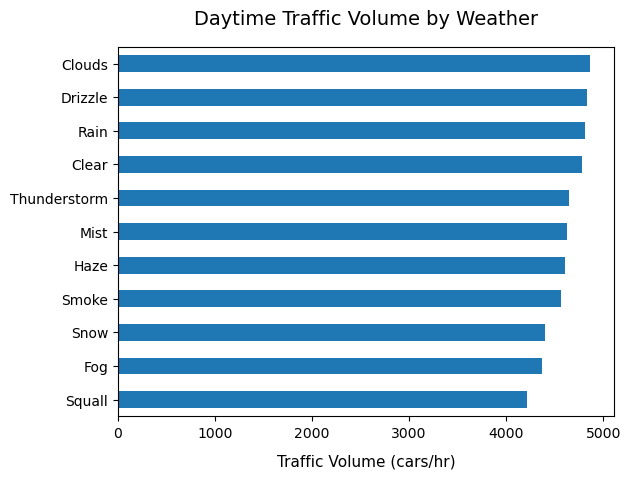

In [27]:
weather_main = daytime.groupby('weather_main')

plot_avg_traffic_barh(weather_main['traffic_volume'], 'Daytime Traffic Volume by Weather')

plt.show()

It appears this column does not provide any outliers in the data. So, let's examine `weather_description` and see if that column gives us more to go on.

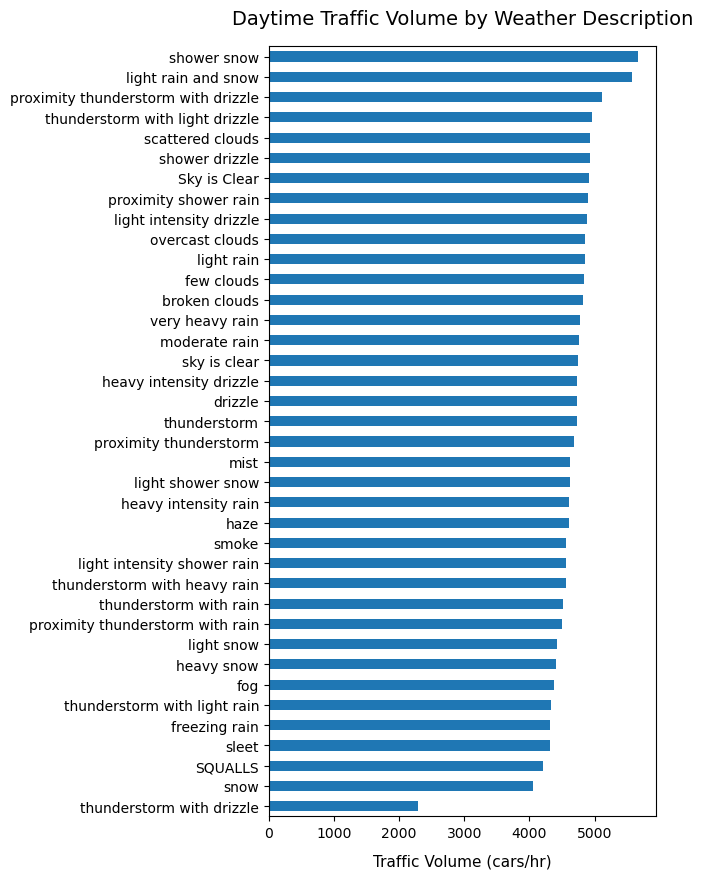

In [28]:
weather_description = daytime.groupby('weather_description')

plt.figure(figsize=(5, 10))
plot_avg_traffic_barh(weather_description['traffic_volume'], 'Daytime Traffic Volume by Weather Description')

plt.show()

Much better!

We can see there are three types of weather that cause traffic volume to exceed 5,000 cars:
* `shower snow`
* `light rain and snow`
* `proximity thunderstorm with drizzle`

Let's measure these against when the `Sky is Clear`

In [29]:
wd_means = weather_description['traffic_volume'].mean()

shower_snow_diff = wd_means['shower snow'] - wd_means['Sky is Clear']
rain_and_snow_diff = wd_means['light rain and snow'] - wd_means['Sky is Clear']
thunderstorm_diff = wd_means['proximity thunderstorm with drizzle'] - wd_means['Sky is Clear']

print('Shower snow: {}'.format(shower_snow_diff))
print('Light rain and snow: {}'.format(rain_and_snow_diff))
print('Proximity thunderstorm with drizzle: {}'.format(thunderstorm_diff))

# Storing for later
traffic_diff['shower snow vs clear skies'] = shower_snow_diff
traffic_diff['light rain and snow vs clear skies'] = rain_and_snow_diff
traffic_diff['proximity thunderstorm with drizzle vs clear skies'] = thunderstorm_diff

Shower snow: 744.9906103286385
Light rain and snow: 660.7406103286385
Proximity thunderstorm with drizzle: 202.8239436619715


**Take Away**
* *Shower snow* is an indicator of heavy traffic with 744 more cars per hour than clear skies.
* *Light rain and snow* is an indicator of heavy traffic with 660 more cars per hour than clear skies.
* *Proximity thunderstorm with drizzle* is an indicator of heavy traffic with 202 more cars per hour than clear skies.

___

## 6. Visualizing Measurements

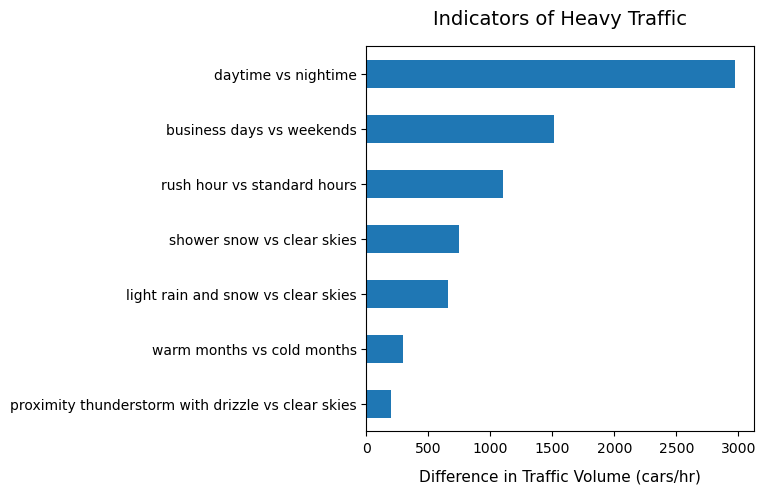

In [30]:
plt.figure(figsize=(5, 5))
plot_avg_traffic_barh(traffic_diff, 'Indicators of Heavy Traffic')
plt.xlabel('Difference in Traffic Volume (cars/hr)', labelpad=10, fontsize='11')

plt.show()

___

## 7. Conclusion
This project aimed to find indicators of heavy traffic on the Interstate 94 Highway.

We found the largest indicators of heavy traffic to be:
* Daylight (7am–7pm) – an average of **2,977** more cars per hour.
* Business days (Monday–Friday) – an average of **1510** more cars per hour.
* Rush hour (7am & 4pm) – an average of **1104** more cars per hour.
* Warm months (March–October) – an average of **299** more cars per hour.

We also found certain weather to be an indicator of heavy traffic:
* Shower snow – an average of **744** more cars per hour.
* Light rain and snow – an average of **660** more cars per hour.
* Proximity thunderstorm with drizzle – an average of **202** more cars per hour.